# Neural Network model to identify yoga poses

This notebook explores model approaches for an optimal classification of yoga poses.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score


from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Data Preprocessing

First, we download import the pose data into the notebook:

In [2]:
df = pd.read_csv('pose_landmark_data_10.csv')
cols_to_drop = [col for col in df.columns if col.endswith('visibility') or col.endswith('presence')]
df = df.drop(columns=cols_to_drop)


We then split the data into independent variables (X) and dependent variables (y). Afterwards, we tranform the targets into number valies, scale the features, and OneHotEncode the targets.

In [22]:

X = df.iloc[ : , : len(df.columns)-1 ]
y = df['pose']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=11,
                                                    stratify=y)



numdict_y = {label: pose for pose, label in enumerate(np.unique(y))}
y_train_numerical = np.array([numdict_y[label] for label in y_train])
y_test_numerical = np.array([numdict_y[label] for label in y_test])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X)

y_train_encoded = to_categorical(y_train_numerical)
y_test_encoded = to_categorical(y_test_numerical)


## Model Setup

In [24]:

def model_init():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(numdict_y), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = model_init()

print(model.summary())

es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=0,
    restore_best_weights=True,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               12800     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
Total params: 25866 (101.04 KB)
Trainable params: 2586

Epoch 1/50
39/39 [==============================] - 1s 16ms/step - loss: 1.9574 - accuracy: 0.3499 - val_loss: 1.6627 - val_accuracy: 0.4072
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 1.4756 - accuracy: 0.5310 - val_loss: 1.1779 - val_accuracy: 0.6352
Epoch 3/50
39/39 [==============================] - 0s 12ms/step - loss: 1.0604 - accuracy: 0.6664 - val_loss: 0.8955 - val_accuracy: 0.7264
Epoch 4/50
39/39 [==============================] - 0s 13ms/step - loss: 0.8231 - accuracy: 0.7406 - val_loss: 0.7631 - val_accuracy: 0.7459
Epoch 5/50
39/39 [==============================] - 0s 12ms/step - loss: 0.6883 - accuracy: 0.7675 - val_loss: 0.6602 - val_accuracy: 0.7687
Epoch 6/50
39/39 [==============================] - 0s 12ms/step - loss: 0.6006 - accuracy: 0.7977 - val_loss: 0.6108 - val_accuracy: 0.8013
Epoch 7/50
39/39 [==============================] - 0s 12ms/step - loss: 0.5426 - accuracy: 0.8026 - val_loss: 0.5381 - val_accuracy: 0.8046
Epoch 8/50
39

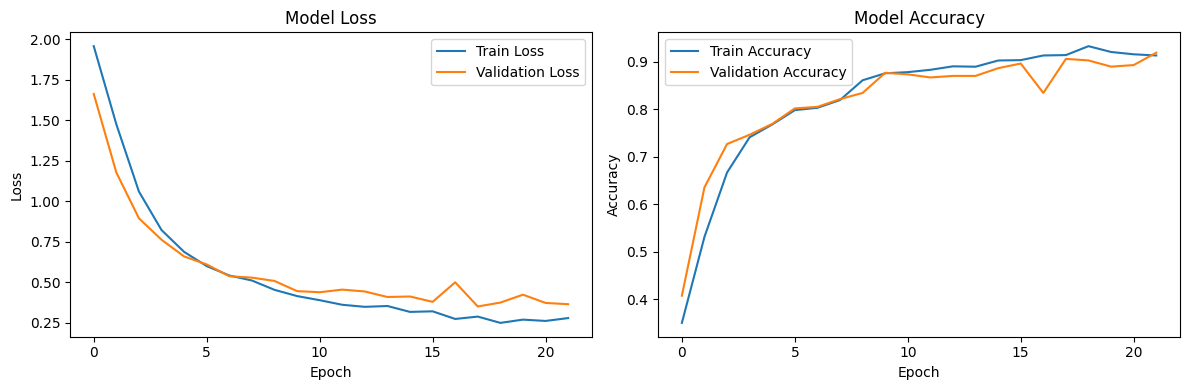

In [25]:
history = model.fit(X_train,
                    y_train_encoded,
                    epochs=50,
                    validation_split = 0.2,
                    verbose = 1,
                    callbacks = es)

def plot_history(history):
    # Set up a plotting area with 1 row and 2 columns
    plt.figure(figsize=(12, 4))  # Optional: Adjust the figure size as needed

    # Plot for loss
    plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st subplot)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd subplot)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()  # Adjust the layout to not overlap
    plt.show()

# Assuming 'history' is the object returned by model.fit()
plot_history(history)


In [27]:
results = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')

21/21 [==============================] - 0s 7ms/step - loss: 0.3565 - accuracy: 0.9102
Test Accuracy: 91.02%
Test Loss: 0.3564581274986267
